In [18]:
%load_ext autoreload
%autoreload 2

In [19]:
import itertools
import pickle
import glob
import os
import re
import string

import numpy as np

import scipy.io

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import tqdm as tqdm

from crosspy.core.synchrony import cplv, wpli
from crosspy.preprocessing.signal import filter_data

from utils.fooof_utils import get_foofed_spectrum_chanwise

from utils.stats import bootstrap_pac_plv_sens, bootstrap_statistic, compute_cohort_binned_plv
from utils.stats import bootstrap_pac_sync_corr, compute_surr_pac_sync_corr, compute_cohort_pac_sync_corr, compute_pac_plv_sens, compute_pac_plv_sens_surr
from utils.io import load_mop, load_electrodes, load_montage, fix_mop, load_psd_data, is_bipolar
from utils.preprocessing import create_bipolar_ref_mask
from utils.colors import okabe, ripples_blue
from utils.pyutils import convert_to_array
from utils.pac import extract_pac_lengths

%config InlineBackend.figure_format = 'jpg'

from joblib import Parallel, delayed

from matplotlib import rcParams
rcParams['font.family'] = 'arial'

cusignal not found!


In [20]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=okabe)

d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [21]:
n_cortical = 100
lags_cycles = np.arange(200)/10

In [22]:
joblib_tmp_dir = 'joblib_temp'

parcel_lut_path = f'meso_data/Schaefer2018_{n_cortical}Parcels_17Networks_order_LUT.txt'.format(n_cortical)
data_root = '../seeg_phases/data/SEEG_redux_BIDS/'

pial_rh_fname = 'meso_data/fsaverage6/surf/rh.pial'
inflated_rh_fname = 'meso_data/fsaverage6/surf/rh.inflated'
annot_rh_fname = f'meso_data/fsaverage6/label/rh.Schaefer2018_{n_cortical}Parcels_17Networks_order.annot'

pial_lh_fname = 'meso_data/fsaverage6/surf/lh.pial'
inflated_lh_fname = 'meso_data/fsaverage6/surf/lh.inflated'
annot_lh_fname = f'meso_data/fsaverage6/label/lh.Schaefer2018_{n_cortical}Parcels_17Networks_order.annot'

In [23]:
res_path = os.path.join('meso_data', 'pac_signal_frequency_7.5', 'pac_sub*.pickle')
res_files = glob.glob(res_path)
print(len(res_files))

68


In [24]:
def load_statistics_data(subject_number):
    return pickle.load(open(f'meso_data/dynamic_statistics/sub-{subject_number}_spectrum.pickle', 'rb'))

In [25]:
bad_subjects = ['02', # weird mop
                '06',
                '40',
                '42',
                '57',
                '19']

In [26]:
meta_data_subjects = pickle.load(open('meso_data/meta_data_subjects.pickle', 'rb'))

In [10]:
cohort_pacf_lifetimes = list()
noise_channelwise_lengths = list()
cohort_parcels = list()

cohort_cplv_values = list()
cohort_ref_masks = list()
cohort_numbers = list()
cohort_psd_foofed = list()


for fname in res_files:
    subj_num = re.findall(r'\d+', fname)[~0]
    
    if subj_num in  bad_subjects:
        print('passing', subj_num)
        continue
    
    subj_montage = meta_data_subjects[subj_num]['montage']
    bipolar_mask = subj_montage['name'].apply(is_bipolar)
    subj_montage = subj_montage[bipolar_mask]
    subj_chans = subj_montage['name'].tolist()
    
    subj_mop = meta_data_subjects[subj_num]['mop']
    subj_mop = fix_mop(subj_mop, bipolar_mask)

    subj_parcels = subj_mop['parcel_assign']
    
    subj_statistics = load_statistics_data(subj_num)
    f_vals = subj_statistics['frequencies']
    subj_res = pickle.load(open(fname, 'rb'))

    if np.array_equal(subj_chans, subj_mop['channel_names']) == False:
        index_mapper = [subj_chans.index(n) for n in subj_mop['channel_names']]
        subj_parcels = subj_parcels[index_mapper]
    
    subj_lengths_channelwise = extract_pac_lengths(subj_res['data_pac'], lags_cycles)
    subj_noise_lengths_channelwise = extract_pac_lengths(subj_res['noise_pac'], lags_cycles)
    
    subj_ref_mask = create_bipolar_ref_mask(subj_chans)
    subj_cplv_values = subj_statistics['cplv_values']
    
    index_mapper = [subj_statistics['ch_names'].index(n) for n in subj_chans]
    
    subj_ref_mask = subj_ref_mask[index_mapper][:, index_mapper]
    subj_cplv_values = subj_cplv_values[:, index_mapper][..., index_mapper]
    
    subj_psd_statistics = load_psd_data(subj_num)
    subj_psd_foofed = get_foofed_spectrum_chanwise(subj_psd_statistics['psd_frequencies'], subj_psd_statistics['psd'], 
                                                   freqs_to_map=subj_statistics['frequencies'])

    subj_psd_foofed = subj_psd_foofed[..., index_mapper]

    cohort_pacf_lifetimes.append(subj_lengths_channelwise)
    noise_channelwise_lengths.append(subj_noise_lengths_channelwise)
    cohort_parcels.append(subj_parcels)

    cohort_cplv_values.append(subj_cplv_values)
    cohort_ref_masks.append(subj_ref_mask)
    cohort_psd_foofed.append(subj_psd_foofed)
    
    
f_vals = np.array(subj_res['f_vals'])

cohort_parcels = convert_to_array(cohort_parcels)
cohort_pacf_lifetimes = convert_to_array(cohort_pacf_lifetimes)
noise_channelwise_lengths = convert_to_array(noise_channelwise_lengths)
cohort_psd_foofed = convert_to_array(cohort_psd_foofed)

passing 02
passing 06


d:\Vlad\projects\seeg_mesoarchitecture\utils\pac.py:38: RuntimeWarning: invalid value encountered in true_divide
  cdf /= cdf.sum()


passing 19
passing 40
passing 42
passing 57


In [11]:
surr_data = np.random.normal(size=(100,300000))
surr_plv = np.zeros((len(f_vals),100,100))
surr_wpli = np.zeros((len(f_vals),100,100))

for freq_idx, freq in enumerate(tqdm.tqdm(f_vals)):
    surr_complex = filter_data(surr_data, 1000, freq, 7.5, n_jobs='cuda')
    surr_plv[freq_idx] = np.abs(cplv(surr_complex, is_normed=False).get())
    surr_wpli[freq_idx] = np.abs(wpli(surr_complex, is_normed=False).get())

noise_level = np.percentile(np.concatenate(noise_channelwise_lengths, axis=-1), 90, axis=-1)
plv_surr_level = surr_plv.mean(axis=(-1,-2))*3.42
wpli_surr_level = surr_wpli.mean(axis=(-1,-2))*3.42

100%|██████████| 81/81 [00:21<00:00,  3.80it/s]


In [12]:
pac_plv_bins, cohort_binned_plv = compute_cohort_binned_plv(cohort_cplv_values, cohort_pacf_lifetimes, cohort_ref_masks, n_bins=10)
binned_plv = np.nanmean(cohort_binned_plv, axis=0)

C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [13]:
meg_pac_results_new = pickle.load(open('meso_data/meg_pac_with_statistics_wpli.pickle', 'rb'))

In [14]:
meg_recall_boot = bootstrap_pac_plv_sens(meg_pac_results_new['average_pac'], np.abs(meg_pac_results_new['wpli']), np.ones((54, 400, 400), dtype=bool), noise_level, wpli_surr_level, n_rounds=320, n_jobs=16, temp_folder=joblib_tmp_dir)

meg_recall_mean = np.nanmean(meg_recall_boot, axis=0)
meg_recall_5, meg_recall_95 = np.nanpercentile(meg_recall_boot, (5,95), axis=0)

In [15]:
meg_pac_wpli_bins, meg_binned_wpli = compute_cohort_binned_plv(np.abs(meg_pac_results_new['wpli']), meg_pac_results_new['average_pac'])

In [16]:
pac_plv_recall_surr = compute_pac_plv_sens_surr(cohort_pacf_lifetimes, cohort_cplv_values, cohort_ref_masks, noise_level, plv_surr_level, n_rounds=32, n_jobs=32)

In [17]:
spec_surr_mean = pac_plv_recall_surr.mean()
spec_surr_low, spec_surr_high = np.percentile(pac_plv_recall_surr.mean(axis=(-1)), (5,95))

In [18]:
kur_reg_data = pickle.load(open('meso_data/kuramoto_plv_vs_pac.pickle', 'rb'))
sim_plv_ticks = kur_reg_data['pac_bins'][:,33].mean(axis=0)

sim_to_plot = pickle.load(open('meso_data/fig_5_sim_data.pickle', 'rb'))
sim_to_plot['pac_values'] *= 12

In [19]:
kuramoto_data = pickle.load(open('meso_data/kuramoto_pac_plv.pickle', 'rb'))
kuramoto_cohort_data = pickle.load(open('meso_data/kuramoto_pac_plv_cohort.pickle', 'rb'))

#compensate for lower number of samples, fix it ?
kuramoto_plv_surr_level = plv_surr_level*1.5

_, kur_pac_plv_recall = compute_pac_plv_sens(kuramoto_cohort_data['pac'], np.abs(kuramoto_cohort_data['plv']), np.ones((50,100,100), dtype=bool), np.percentile(kuramoto_data['surr'], 99, axis=-1), kuramoto_plv_surr_level)

In [20]:
kur_recall_mean = kur_pac_plv_recall.mean(axis=0)

kur_recall_5, kur_recall_95 = kur_recall_mean - kur_pac_plv_recall.std(axis=0)/2, kur_recall_mean + kur_pac_plv_recall.std(axis=0)/2

In [21]:
surr_pac_node_sync_corr = compute_surr_pac_sync_corr(cohort_pacf_lifetimes, cohort_cplv_values, cohort_ref_masks, n_rounds=100, n_jobs=32)

In [22]:
surr_pac_sync_corr_5, surr_pac_sync_corr_95 = np.percentile(surr_pac_node_sync_corr, (5,95), axis=(0,1))
surr_pac_sync_corr_mean = surr_pac_node_sync_corr.mean(axis=(0,1))

In [23]:
seeg_pac_node_sync_corr = compute_cohort_pac_sync_corr(cohort_pacf_lifetimes, cohort_cplv_values, cohort_ref_masks)
meg_pac_node_sync_corr = compute_cohort_pac_sync_corr(meg_pac_results_new['average_pac'], np.abs(meg_pac_results_new['wpli']), np.ones((54, 400, 400), dtype=bool))
kur_pac_node_sync_corr = compute_cohort_pac_sync_corr(kuramoto_cohort_data['pac'], np.abs(kuramoto_cohort_data['plv']), np.ones((50,100,100), dtype=bool))

In [24]:
seeg_pac_node_sync_corr = bootstrap_pac_sync_corr(cohort_pacf_lifetimes, cohort_cplv_values, cohort_ref_masks, n_jobs=8)
seeg_pac_node_sync_5, seeg_pac_node_sync_95 = np.percentile(seeg_pac_node_sync_corr, (5,95), axis=0)


In [25]:
meg_pac_node_sync_corr = bootstrap_pac_sync_corr(meg_pac_results_new['average_pac'].astype(np.float32), np.abs(meg_pac_results_new['wpli']).astype(np.float32), np.ones((54, 400, 400), dtype=bool), n_jobs=10)
meg_pac_node_sync_5, meg_pac_node_sync_95 = np.percentile(meg_pac_node_sync_corr, (5,95), axis=0)

In [26]:
kur_pac_node_sync_corr = bootstrap_pac_sync_corr(kuramoto_cohort_data['pac'], np.abs(kuramoto_cohort_data['plv']), np.ones((50,100,100), dtype=bool), n_jobs=32)
kur_pac_node_sync_5, kur_pac_node_sync_95 = np.percentile(kur_pac_node_sync_corr, (5,95), axis=0)

In [27]:
seeg_recall_boot = bootstrap_pac_plv_sens(cohort_pacf_lifetimes, cohort_cplv_values, cohort_ref_masks, noise_level, plv_surr_level, n_rounds=320, n_jobs=32)
seeg_recall_mean = np.nanmean(seeg_recall_boot, axis=0)
seeg_recall_5, seeg_recall_95 = np.nanpercentile(seeg_recall_boot, (5,95), axis=0)

C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


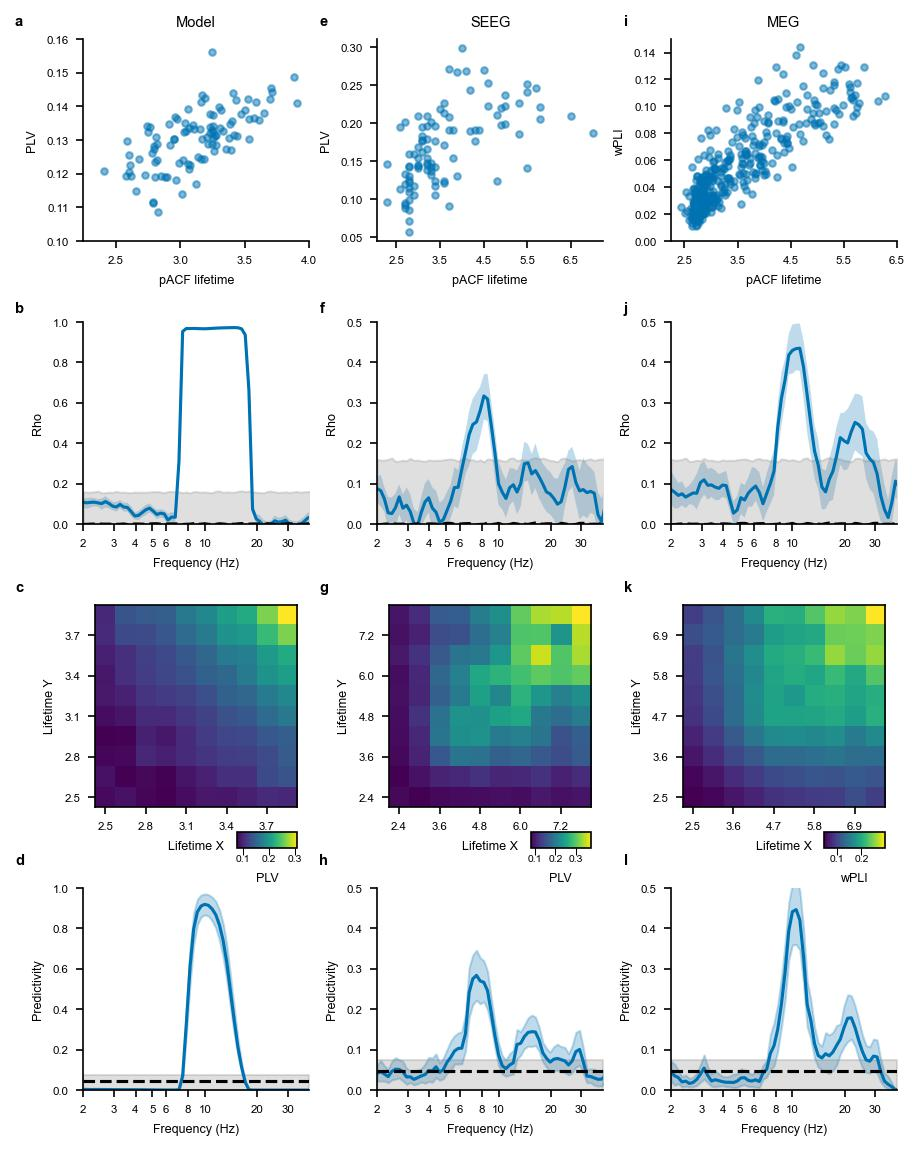

In [58]:
i,j = 7, 30 # 7 - subject with nice but not the higher correlation, 30 - peak in spectrum

fig, axes = plt.subplots(figsize=(7, 9.1), ncols=3, nrows=4, dpi=150,  gridspec_kw={'hspace': 0.4, 'wspace':0.3})

cbar_axes = [axes[2,i].inset_axes([0.7, -0.2, 0.3, 0.075]) for i in range(3)]

axes[0,0].scatter(sim_to_plot['pac_values'][7,8,:,10:50].mean(axis=-1), np.abs(sim_to_plot['cplv_values'][7,8]).mean(axis=-1), s=10, alpha=0.5, color=ripples_blue)
axes[0,1].scatter(cohort_pacf_lifetimes[6][30], np.abs(cohort_cplv_values[6][30]).mean(axis=0), s=10, alpha=0.5, color=ripples_blue)
axes[0,2].scatter(meg_pac_results_new['average_pac'][13, 35], np.abs(meg_pac_results_new['wpli'][13, 35]).mean(axis=0), s=10, alpha=0.5, color=ripples_blue)

axes[1,0].semilogx(f_vals, kur_pac_node_sync_corr.mean(axis=0))
axes[1,0].fill_between(f_vals, kur_pac_node_sync_5, kur_pac_node_sync_95, alpha=0.25)

axes[1,0].semilogx(f_vals, surr_pac_sync_corr_mean, color='black', ls='--')
axes[1,0].fill_between(f_vals, surr_pac_sync_corr_5, surr_pac_sync_corr_95, color='gray', alpha=0.25)

axes[1,1].semilogx(f_vals, seeg_pac_node_sync_corr.mean(axis=0))
axes[1,1].fill_between(f_vals, seeg_pac_node_sync_5, seeg_pac_node_sync_95, alpha=0.25)

axes[1,1].semilogx(f_vals, surr_pac_sync_corr_mean, color='black', ls='--')
axes[1,1].fill_between(f_vals, surr_pac_sync_corr_5, surr_pac_sync_corr_95, color='gray', alpha=0.25)

axes[1,2].semilogx(f_vals, meg_pac_node_sync_corr.mean(axis=0))
axes[1,2].fill_between(f_vals, meg_pac_node_sync_5, meg_pac_node_sync_95, alpha=0.25)

axes[1,2].semilogx(f_vals, surr_pac_sync_corr_mean, color='black', ls='--')
axes[1,2].fill_between(f_vals, surr_pac_sync_corr_5, surr_pac_sync_corr_95, color='gray', alpha=0.25)

imh_plv_sim = axes[2,0].imshow(np.nanmean(kur_reg_data['plv_binned'][:,33], axis=0), origin='lower')
imh = axes[2,1].imshow(binned_plv[30], origin='lower')
imh_wpli = axes[2,2].imshow(np.nanmean(meg_binned_wpli, axis=0)[35], origin='lower', cmap='viridis')

axes[3,0].semilogx(f_vals, kur_recall_mean, color=ripples_blue)
axes[3,0].fill_between(f_vals, kur_recall_5, kur_recall_95, color=ripples_blue, alpha=0.25)
axes[3,0].hlines(spec_surr_mean, 2, 40, color='black', ls='--')
axes[3,0].fill_between([2,40], [0, 0], [spec_surr_high, spec_surr_high], color='gray', alpha=0.25)

axes[3,1].semilogx(f_vals, seeg_recall_mean, color=ripples_blue)
axes[3,1].fill_between(f_vals, seeg_recall_5, seeg_recall_95, color=ripples_blue, alpha=0.25)
axes[3,1].hlines(spec_surr_mean, 2, 40, color='black', ls='--')
axes[3,1].fill_between([2,40], [0, 0], [spec_surr_high, spec_surr_high], color='gray', alpha=0.25)

axes[3,2].semilogx(f_vals, meg_recall_mean, color=ripples_blue)
axes[3,2].fill_between(f_vals, meg_recall_5, meg_recall_95, color=ripples_blue, alpha=0.25)
axes[3,2].hlines(spec_surr_mean, 2, 40, color='black', ls='--')
axes[3,2].fill_between([2,40], [0, 0], [spec_surr_high, spec_surr_high], color='gray', alpha=0.25)

fig.colorbar(imh_plv_sim, cax=cbar_axes[0], orientation='horizontal')
fig.colorbar(imh, cax=cbar_axes[1], orientation='horizontal')
fig.colorbar(imh_wpli, cax=cbar_axes[2], orientation='horizontal')


for ax, ticks in zip(axes[2], [sim_plv_ticks*4, pac_plv_bins[:,30].mean(axis=0), meg_pac_wpli_bins[:,35].mean(axis=0)]):
    ax.set_xticks(np.arange(10)[::2], labels=np.round(ticks[::2], 2).round(1))
    ax.set_yticks(np.arange(10)[::2], labels=np.round(ticks[::2], 2).round(1))


for ax, ylabel, title in zip(axes[0], ['PLV', 'PLV', 'wPLI'], ['Model', 'SEEG', 'MEG']):
    ax.set_ylabel(ylabel, fontsize=6)
    ax.set_xlabel('pACF lifetime', fontsize=6)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_title(title, fontsize=7)
    
for ax in axes[2]:
    ax.set_xlabel('Lifetime X', fontsize=6)
    ax.set_ylabel('Lifetime Y', fontsize=6)


for ax, ymax in zip(axes[3], [1.0, 0.5, 0.5]):
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.minorticks_off()
    
    ax.set_xticks([2,3,4,5,6,8,10,20,30])
    
    ax.set_xlim([f_vals[0], 40])
    ax.set_xlabel('Frequency (Hz)', fontsize=6)
    ax.set_ylabel('Predictivity', fontsize=6)
    
    ax.set_ylim([-0, ymax])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for ax, ymax in zip(axes[1], [1.0, 0.5, 0.5]):
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.minorticks_off()
    
    # ax.set_xticks(2**np.arange(1,7))
    ax.set_xticks([2,3,4,5,6,8,10,20,30])
    
    ax.set_xlim([f_vals[0], 40])
    ax.set_xlabel('Frequency (Hz)', fontsize=6)
    ax.set_ylabel('Rho', fontsize=6)
    
    ax.set_ylim([-0, ymax])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
axes[0,0].set_xlim([2.25, 4])
axes[0,0].set_ylim([0.1, 0.16])

axes[0,2].set_ylim([0.0, 0.15])

axes[0,1].set_xticks([2.5, 3.5, 4.5, 5.5, 6.5])
axes[0,2].set_xticks([2.5, 3.5, 4.5, 5.5, 6.5])

for ax in axes.flatten().tolist() + cbar_axes:
    ax.tick_params(labelsize=5.5)

for ax, label in zip(cbar_axes, ['PLV', 'PLV', 'wPLI']):
    ax.set_xlabel(label, fontsize=6)
    ax.xaxis.set_tick_params(labelsize=5, pad=0, width=0.5) 

    
# for ax, label in zip(axes.flatten().tolist(), string.ascii_lowercase):
#     ax.text(-0.35, 1., label, fontsize=7, transform=ax.transAxes, weight='bold')

for label, (xpos, ypos) in zip(string.ascii_lowercase, itertools.product([0.06, 0.35, 0.64], [0.89, 0.68, 0.475, 0.275])):
    fig.text(xpos, ypos, label, fontsize=7, weight='bold')
    
# fig.tight_layout()
    
fig.savefig('publication_figures/figure_6.png', dpi=300, bbox_inches='tight')

for format in ['svg', 'pdf']:
    fig.savefig(f'publication_figures_vector/figure_6.{format}', dpi=300, bbox_inches="tight")